# CNIT 484 Final Project #
## Financial Analysis ##

#### Libraries and GPU testing
Add more as needed. Make sure to add to requirements.txt as well.

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import math
from tempfile import TemporaryDirectory
import time
import os
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.version.cuda)
print(torch.cuda.is_available())
print("Num GPUs Available: ", torch.cuda.device_count())
print(device)

12.1
True
Num GPUs Available:  1
cuda


## Loading Data

In [346]:
raw_data = pd.read_csv("../Datasets/1_ETHUSDT_1.1.2018-1.2.2024_1hour.csv", header=None)
print(raw_data.head())
print(raw_data.shape)


                    0       1       2       3       4           5   \
0  2017-12-31 19:00:00  733.01  734.52  720.03  727.62  2105.90100   
1  2017-12-31 20:00:00  727.01  732.00  716.80  717.97  2305.97086   
2  2017-12-31 21:00:00  717.67  725.75  717.59  724.05  2166.45725   
3  2017-12-31 22:00:00  723.95  737.99  722.70  734.50  2160.90450   
4  2017-12-31 23:00:00  734.99  744.98  730.01  744.82  2335.33705   

              6             7     8           9              10  11  
0  1514768399999  1.528559e+06  3114  1275.23271  925445.068280   0  
1  1514771999999  1.675753e+06  2875  1035.33513  753211.787422   0  
2  1514775599999  1.564151e+06  2957  1179.82843  851942.067625   0  
3  1514779199999  1.582200e+06  3647  1095.63271  801470.072777   0  
4  1514782799999  1.724788e+06  3512  1313.03081  970430.311743   0  
(53207, 12)


## Preprocessing ##

#### Data Modification ####

                       open    high     low   close      volume  next_close
date                                                                       
2017-12-31 19:00:00  733.01  734.52  720.03  727.62  2105.90100      717.97
2017-12-31 20:00:00  727.01  732.00  716.80  717.97  2305.97086      724.05
2017-12-31 21:00:00  717.67  725.75  717.59  724.05  2166.45725      734.50
2017-12-31 22:00:00  723.95  737.99  722.70  734.50  2160.90450      744.82
2017-12-31 23:00:00  734.99  744.98  730.01  744.82  2335.33705      748.99
(53206, 6)


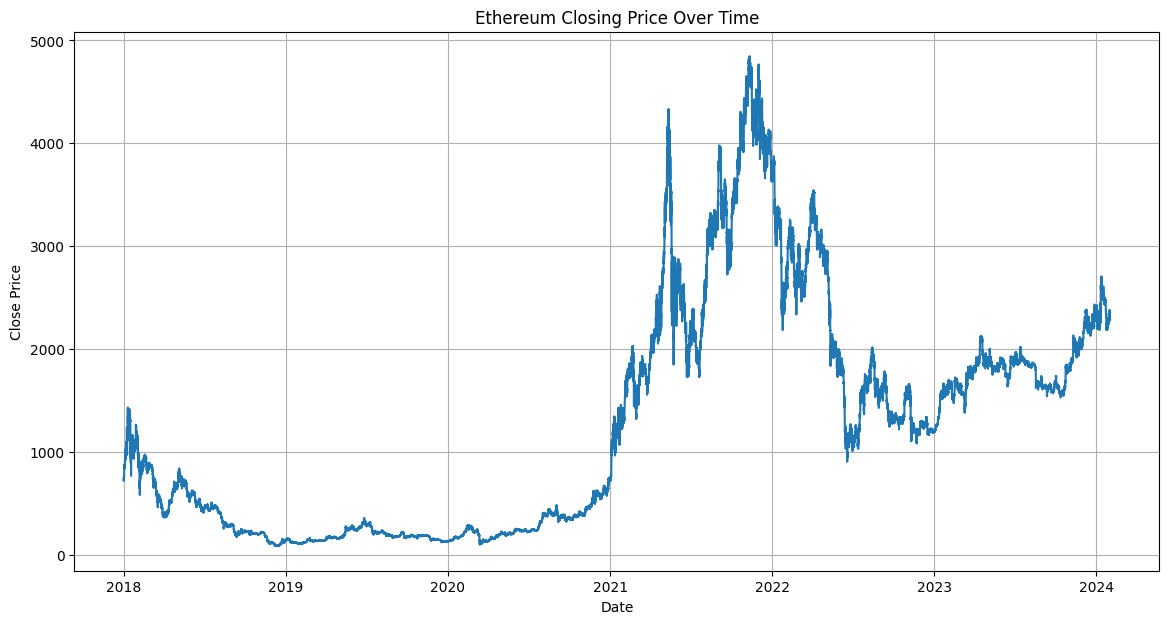

In [347]:
#Label the important columns and drop the rest
raw_data.columns = ['date', 'open', 'high', 'low', 'close', 'volume'] + list(raw_data.columns[6:])
raw_data.drop(raw_data.columns[6:], axis=1, inplace=True)

# Convert the 'date' column to datetime and make it the index
raw_data['date'] = pd.to_datetime(raw_data['date'])
raw_data.set_index('date', inplace=True)

# create next close column which will be used for prediction
raw_data['next_close'] = raw_data['close'].shift(-1)
#drop last value since itll be NaN
cleaned_data = raw_data.dropna()


print(cleaned_data.head())
print(cleaned_data.shape)

plt.figure(figsize=(14, 7))
plt.plot(raw_data['close'])
plt.title('Ethereum Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()


#### Sequencing ####

In [348]:
# takes sequences of inputs and targets, and a sequence length as input.
# Each sample it returns consists of a sequence of inputs and a sequence of targets.
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, sequences, targets, seq_length):
        self.sequences = sequences
        self.targets = targets
        self.seq_length = seq_length

    def __len__(self):
        return self.sequences.shape[0] - self.seq_length - 4  # Adjusted for 5 future 'close' values

    def __getitem__(self, index):
        sequence = self.sequences[index:index+self.seq_length] # get the sequence which is the current index to index + seq_length
        target = self.targets[index+(self.seq_length-1):index+(self.seq_length-1)+5] # the targets are the next 10 values (index+(self.seq_length-1)+10) after the last index (index+(self.seq_length-1))
        return sequence, target

### Define Model ###
Sequence to vector model

In [349]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model % 2 == 0:  # If d_model is even
            pe[:, 1::2] = torch.cos(position * div_term)
        else:  # If d_model is odd
            pe[:, 1::2] = torch.cos(position * div_term)[:,:-1]  # Exclude the last column
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x) -> torch.Tensor:
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, ninp, nhead, nhid, nlayers, n_output, dropout=0.2 ):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=ninp, nhead=nhead, dim_feedforward=nhid, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=nlayers)

        self.decoder = nn.Linear(ninp, ninp)
        self.final_layer = nn.Linear(ninp, n_output) # 5 outputs
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)
        self.final_layer.bias.data.zero_()
        self.final_layer.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.decoder(output)
        output = self.final_layer(output[:,-1])
        return output

#### Hyperparameters

In [350]:
ninp = 5  # Number of expected features in the input
nhead = 5  # Number of heads in the multiheadattention models
nhid = 200  # Dimension of the feedforward network model
nlayers = 2 # Number of encoder layers
dropout = 0.2  # Dropout value
noutput = 5  # Number of outputs


In [351]:
model = TransformerModel(ninp, nhead, nhid, nlayers, noutput, dropout ).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

c:\Users\drejc\OneDrive - purdue.edu\CNIT484\CNIT484\.conda\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


### Data Prep for Transformer

#### Loading and Splitting Data ###

In [353]:
features = cleaned_data[['open', 'high', 'low', 'close', 'volume']]
targets = cleaned_data['next_close']

# Define sequence length
seq_length = 72 # set the number of hours for each sequence

In [354]:
train_size = int(len(features) * 0.7)
val_size = int(len(features) * 0.15)
test_size = len(features) - train_size - val_size

# Split features
features_train = features[:train_size]
features_val = features[train_size:train_size+val_size]
features_test = features[train_size+val_size:]

# Split targets and reshape to 2D array
targets_train = targets[:train_size].values.reshape(-1, 1)
targets_val = targets[train_size:train_size+val_size].values.reshape(-1, 1)
targets_test = targets[train_size+val_size:].values.reshape(-1, 1)

scaler = MinMaxScaler()

# Scale the features
features_train = scaler.fit_transform(features_train)
features_val = scaler.transform(features_val)
features_test = scaler.transform(features_test)

# Scale the targets
targets_scaler = MinMaxScaler()
targets_train = targets_scaler.fit_transform(targets_train)
targets_val = targets_scaler.transform(targets_val)
targets_test = targets_scaler.transform(targets_test)

# Create datasets
train_dataset = TimeSeriesDataset(torch.FloatTensor(features_train), torch.FloatTensor(targets_train), seq_length)
val_dataset = TimeSeriesDataset(torch.FloatTensor(features_val), torch.FloatTensor(targets_val), seq_length)
test_dataset = TimeSeriesDataset(torch.FloatTensor(features_test), torch.FloatTensor(targets_test), seq_length)

In [355]:
print(f"Shape of sequences: {train_dataset[0][0].shape}")
print(f"Number of sequences in train dataset: {len(train_dataset)}")
print(f"Number of sequences in test dataset: {len(test_dataset)}")
print(f"Number of sequences in val dataset: {len(val_dataset)}")


Shape of sequences: torch.Size([72, 5])
Number of sequences in train dataset: 37168
Number of sequences in test dataset: 7906
Number of sequences in val dataset: 7904


In [356]:
print(f"Example sequence:\n {train_dataset[0][0]}\n")
print(f"Example target:\n {train_dataset[0][1]}")


Example sequence:
 tensor([[0.1366, 0.1362, 0.1343, 0.1355, 0.0043],
        [0.1353, 0.1356, 0.1336, 0.1334, 0.0047],
        [0.1334, 0.1343, 0.1338, 0.1347, 0.0044],
        [0.1347, 0.1369, 0.1349, 0.1369, 0.0044],
        [0.1370, 0.1384, 0.1364, 0.1391, 0.0047],
        [0.1391, 0.1394, 0.1390, 0.1400, 0.0046],
        [0.1399, 0.1419, 0.1398, 0.1427, 0.0051],
        [0.1427, 0.1422, 0.1406, 0.1406, 0.0048],
        [0.1405, 0.1411, 0.1380, 0.1391, 0.0048],
        [0.1389, 0.1404, 0.1394, 0.1408, 0.0037],
        [0.1410, 0.1413, 0.1406, 0.1417, 0.0033],
        [0.1416, 0.1411, 0.1365, 0.1383, 0.0063],
        [0.1383, 0.1392, 0.1381, 0.1391, 0.0046],
        [0.1394, 0.1388, 0.1364, 0.1378, 0.0055],
        [0.1379, 0.1383, 0.1352, 0.1386, 0.0076],
        [0.1386, 0.1399, 0.1382, 0.1399, 0.0051],
        [0.1398, 0.1392, 0.1371, 0.1379, 0.0038],
        [0.1379, 0.1388, 0.1376, 0.1374, 0.0046],
        [0.1374, 0.1381, 0.1373, 0.1387, 0.0033],
        [0.1387, 0.1394, 0.1389

#### Dataloaders

In [364]:
from torch.utils.data import DataLoader

batch_size = 32  

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### Training

In [369]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()  # training mode
    total_loss = 0
    
    for i, (sequence, target) in enumerate(train_loader):
        sequence, target = sequence.to(device), target.to(device)  # Move sequence and target to the GPU
        optimizer.zero_grad()  # Clear gradients
        output = model(sequence)
        loss = criterion(output.view(-1), target.view(-1))  # Reshape output and target to be 1D
        loss.backward() 
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()  # Update the weights
        total_loss += loss.item()
    return total_loss / len(train_loader)

def validate(model, val_loader, criterion, device):
    model.eval()  # evaluation mode
    total_loss = 0

    with torch.no_grad():  # no need to calculate gradients
        for i, (sequence, target) in enumerate(val_loader):
            sequence, target = sequence.to(device), target.to(device)
            output = model(sequence)
            loss = criterion(output.view(-1), target.view(-1))
            total_loss += loss.item()
    return total_loss / len(val_loader)

In [370]:
for epoch in range(5):  # Number of epochs
    train_loss = train(model, train_dataloader, criterion, optimizer, device)
    val_loss = validate(model, val_dataloader, criterion, device)
    print(f"Epoch: {epoch}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

Epoch: 0, Train Loss: 0.014776056809527174, Validation Loss: 0.06412557207108267
Epoch: 1, Train Loss: 0.014010145271132042, Validation Loss: 0.057342817380964035
Epoch: 2, Train Loss: 0.012982861095700387, Validation Loss: 0.061043906104769785
Epoch: 3, Train Loss: 0.013144140235062612, Validation Loss: 0.049752372260458075
Epoch: 4, Train Loss: 0.012484451715206077, Validation Loss: 0.04933891196542906


In [371]:
def evaluate(model, test_loader, criterion, device):
    model.eval()  # evaluation mode
    total_loss = 0.
    with torch.no_grad():
        for i, (sequence, target) in enumerate(test_loader):
            sequence, target = sequence.to(device), target.to(device)  # Move sequence and target to the GPU
            output = model(sequence)
            loss = criterion(output.view(-1), target.view(-1))  # Reshape output and target to be 1D
            total_loss += loss.item()

    return total_loss / len(test_loader)
# print out the values of the first sequence in test_loader
loss = evaluate(model, test_dataloader, criterion, device)
print(f"Test Loss: {loss}")

Test Loss: 0.0615994923207308


Note: It's important to note that stock price prediction is an extremely challenging problem due to the stochastic nature of financial markets. Factors outside the scope of historical price data can have significant impacts on future prices. Due to this, our model did not perform the best. However, for future developments, it likely would be crucial to implement other contexts and/or more data for the model to be trained on.